In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sqil_core.utils import *
from sqil_experiments.analysis.fit import find_shared_peak
from qutip import *
from scipy.optimize import minimize

### Get data to fit

In [2]:
def get_twotone_data(path):
    datadict = extract_h5_data(path, get_metadata=True)
    qu_data, qu_info, datadict = get_data_and_info(datadict=datadict)
    qu_data, qu_info, datadict = qu_data["q0"], qu_info["q0"], datadict["q0"]
    freq, data, sweeps = qu_data
    return freq, data, sweeps[0], datadict


def fit_traces(freq, data, curr, freq_mask=None, curr_mask=None):
    if freq_mask is None:
        freq_mask = np.ones_like(freq[0], dtype=bool) # Assumes fixed frequency range
    if curr_mask is None:
        curr_mask = np.ones_like(curr, dtype=bool)

    freq = freq[np.ix_(curr_mask, freq_mask)]
    data = data[np.ix_(curr_mask, freq_mask)]
    curr = curr[curr_mask]

    y_fit = np.zeros(len(data))
    for i in range(len(data)):
        f = freq[i]
        mag, phase = np.abs(data[i]), np.angle(data[i])
        try:
            fit_res = find_shared_peak(f, mag, phase)
            if not fit_res or not fit_res.is_acceptable():
                y_fit[i] = np.nan
                continue
            y_fit[i] = fit_res.params_by_name["x0"]
        except:
            y_fit[i] = np.nan

    return curr, y_fit, freq, data

In [55]:
spectrum_dict = {
    # "01 4.5-4.9 left": {
    #     "path": r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-12\00818-qubit_spectroscopy_vs_current_2025-10-12T042459",
    #     "masks": lambda freq, curr: (None, None),
    #     "eval_idx": 1,
    # },
    # "01 3.6-4 left": {
    #     "path": r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-07\00106-qubit_spectroscopy_vs_current_2025-10-07T044306",
    #     "masks": lambda freq, curr: (None, None),
    #     "eval_idx": 1,
    # },
    # "01 3.3-3.5 left": {
    #     "path": r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-12\00819-qubit_spectroscopy_vs_current_2025-10-12T043319",
    #     "masks": lambda freq, curr: (None, None),
    #     "eval_idx": 1,
    # },
    # "10 half flux": {
    #     "path": r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-11\00670-qubit_spectroscopy_vs_current_2025-10-11T045954",
    #     "masks": lambda freq, curr: (None, None),
    #     "eval_idx": 2,
    # },
    # "10 6-6.4 left": {
    #     "path": r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-12\00817-qubit_spectroscopy_vs_current_2025-10-12T041640",
    #     "masks": lambda freq, curr: (None, None),
    #     "eval_idx": 2,
    # },
    "anti-crossing lower": {
        "path": r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-11\00668-qubit_spectroscopy_vs_current_2025-10-11T034016",
        "masks": lambda freq, curr: (freq[0] < 5.48e9, curr < 44.5e-6),
        "eval_idx": 1,
    },
    "anti-crossing upper": {
        "path": r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-11\00668-qubit_spectroscopy_vs_current_2025-10-11T034016",
        "masks": lambda freq, curr: (
            freq[0] > 5.475e9,
            (curr > 43.7e-6) & (curr < 45.5e-6),
        ),
        "eval_idx": 2,
    },
    "11 half flux left": {
        "path": r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-07\00105-qubit_spectroscopy_vs_current_2025-10-07T035837",
        "masks": lambda freq, curr: (None, (curr > 85.5e-6) & (curr < 88.1e-6)),
        "eval_idx": 3,
    },
    "11 half flux right": {
        "path": r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-07\00105-qubit_spectroscopy_vs_current_2025-10-07T035837",
        "masks": lambda freq, curr: (None, curr > 88.5e-6),
        "eval_idx": 3,
    },
    # "11 6-6.4 left": {
    #     "path": r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-12\00816-qubit_spectroscopy_vs_current_2025-10-12T040820",
    #     "masks": lambda freq, curr: (freq[0] > 6.15e9, None),
    #     "eval_idx": 3,
    # },
}

In [26]:
# Base figure
path0 = r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-11\00668-qubit_spectroscopy_vs_current_2025-10-11T034016"
freq, data, curr, datadict = get_twotone_data(path0)
fig, axs = plot_mag_phase(datadict=datadict, transpose=True)
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

spectrum_data_dict = {}
for name, trace_dict in spectrum_dict.items():
    freq, data, curr, datadict = get_twotone_data(trace_dict["path"])
    plot_mag_phase(datadict=datadict, transpose=True, plot=(fig, axs))
    masks = trace_dict["masks"](freq, curr)
    curr_fit, y_fit, *_ = fit_traces(freq, data, curr, *masks)
    fitted_mask = ~np.isnan(y_fit)
    spectrum_data_dict[name] = {
        "current": curr_fit[fitted_mask],
        "data": y_fit[fitted_mask] * 1e-9,
        "eval_idx": trace_dict["eval_idx"]
    }
    axs[0].plot(curr_fit * 1e3, y_fit * 1e-9, color=colors[trace_dict["eval_idx"]])

plt.show()

Lorentzian domninates
 -> nrmse: 0.0709 vs 0.0724
Lorentzian domninates
 -> nrmse: 0.0762 vs 0.0486


c:\Users\sqil\AppData\Local\pypoetry\Cache\virtualenvs\sqil-experiments-gl8RHkKX-py3.12\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\sqil\AppData\Local\pypoetry\Cache\virtualenvs\sqil-experiments-gl8RHkKX-py3.12\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


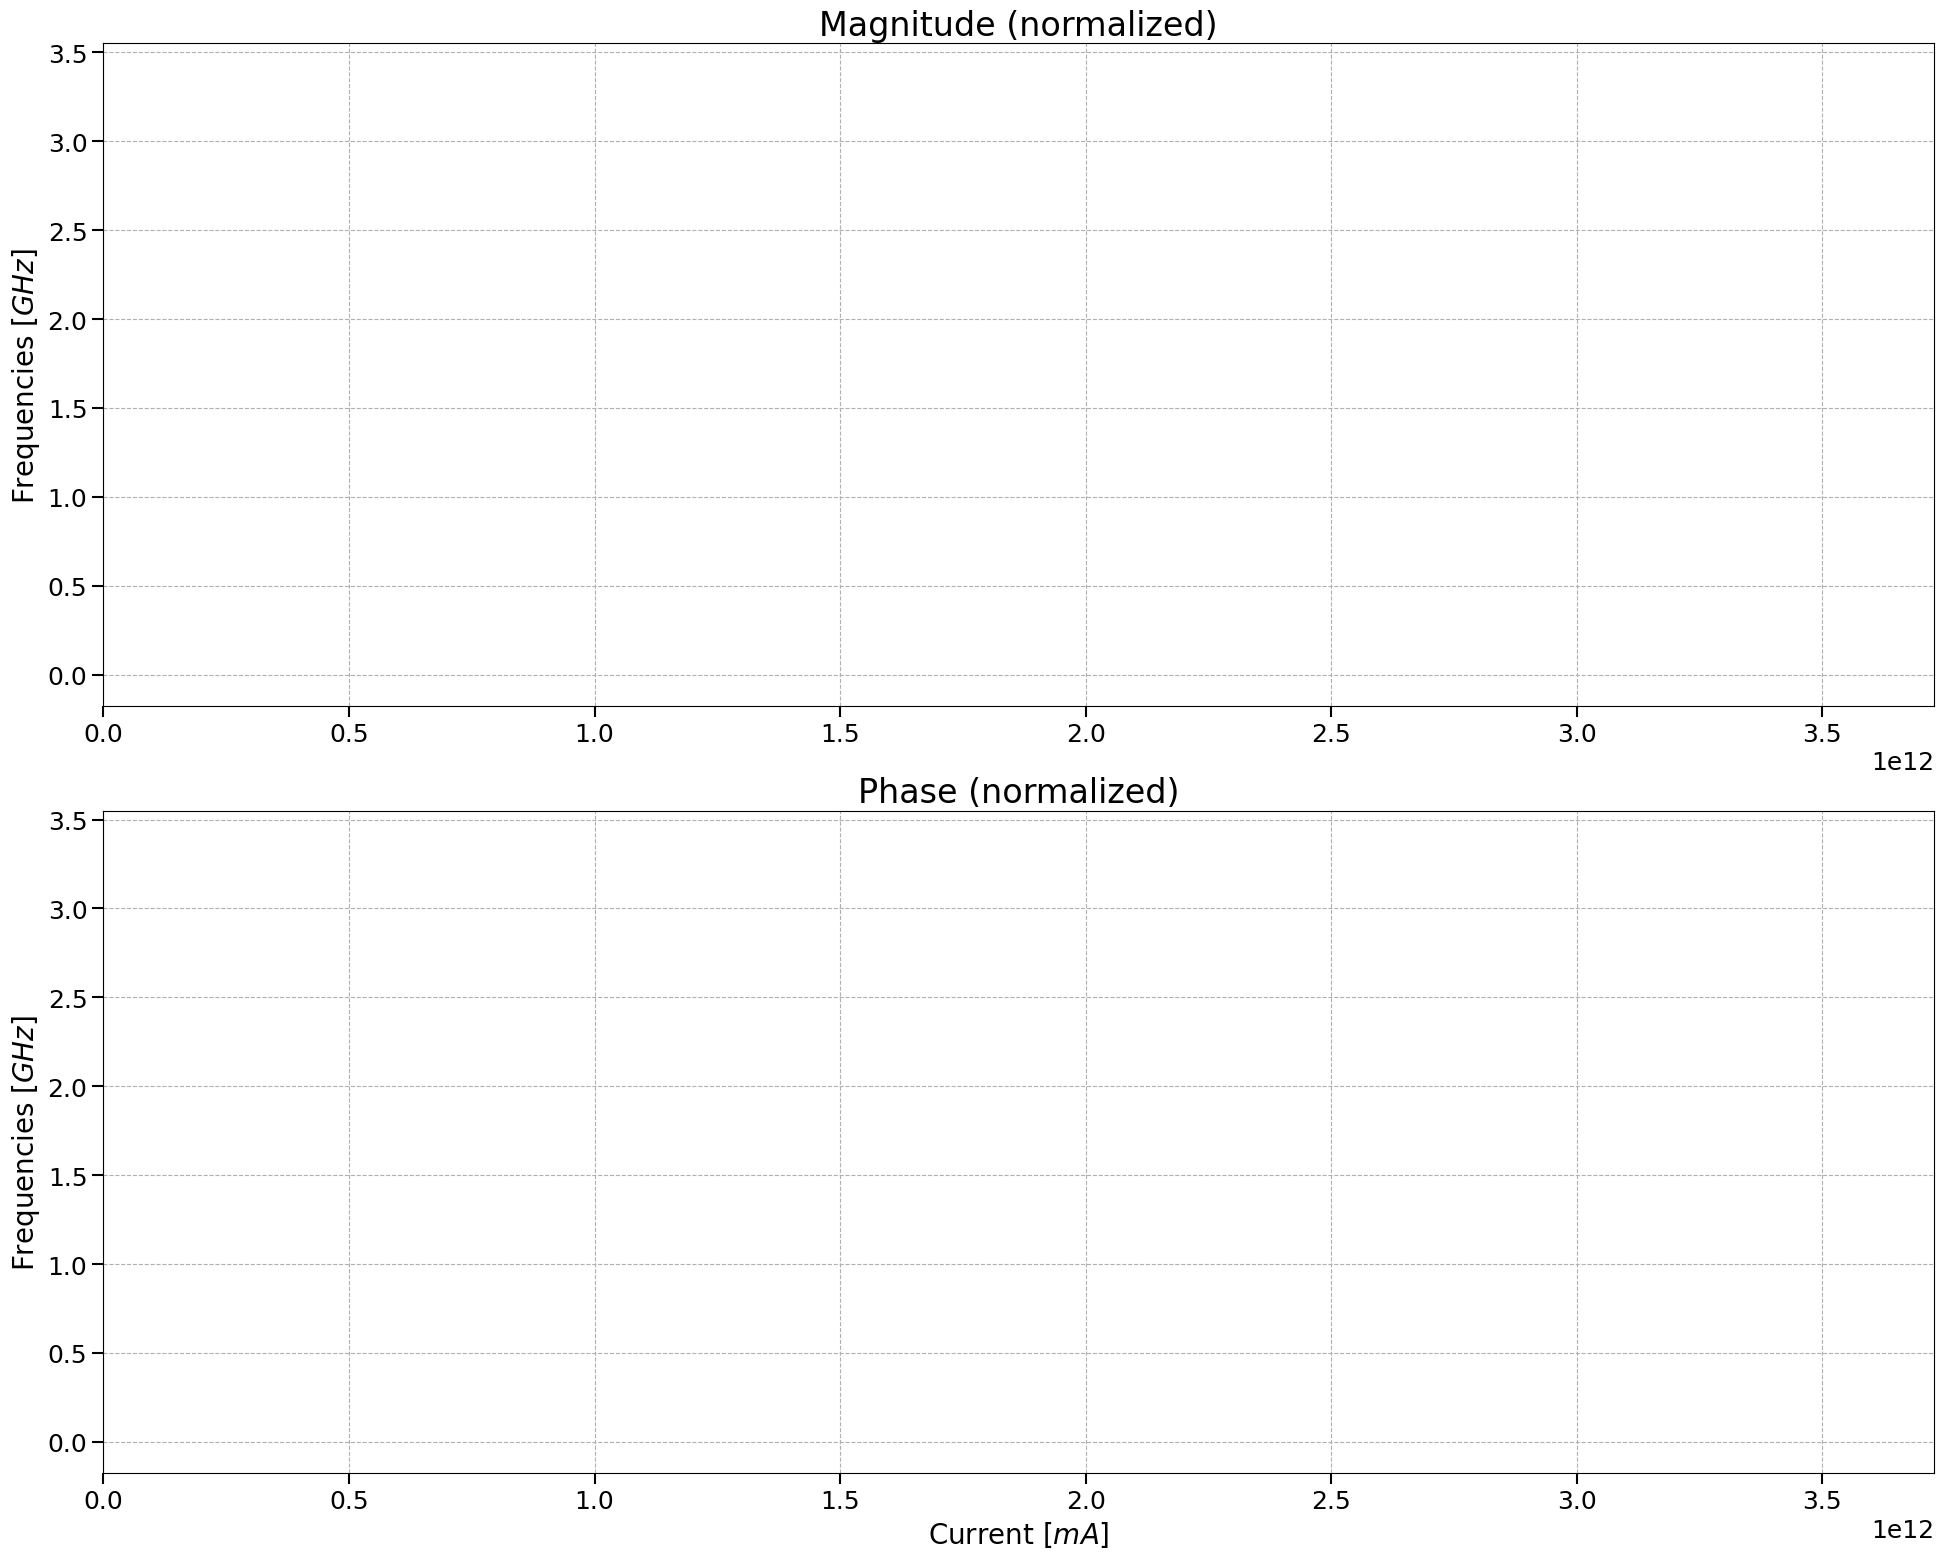

In [5]:
path = r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-12\00819-qubit_spectroscopy_vs_current_2025-10-12T043319"

datadict = extract_h5_data(path, get_metadata=True)
qu_data, qu_info, datadict = get_data_and_info(datadict=datadict)
qu_data, qu_info, datadict = qu_data["q0"], qu_info["q0"], datadict["q0"]
freq, data, sweeps = qu_data
curr = sweeps[0]

fig, axs = plot_mag_phase(datadict=datadict, transpose=True)

freq_mask = None #freq[0] > 6.15e9
curr_mask = None #(curr > 80e-6) 
_, _, curr_fit, y_fit = fit_traces(freq, data, curr, freq_mask, curr_mask)
axs[0].plot(curr_fit * 1e3, y_fit * 1e-9, color="tab:red")

# freq_mask = freq[0] < 5.48e9
# curr_mask = curr < 44.5e-6
# _, _, curr_fit, y_fit = fit_traces(freq, data, curr, freq_mask, curr_mask)
# axs[0].plot(curr_fit * 1e3, y_fit * 1e-9, color="tab:red")

plt.show()

### Helper functions

In [3]:
def current_to_flux(curr, zero_flux_curr, half_flux_curr):
    span = half_flux_curr - zero_flux_curr
    return (curr - zero_flux_curr) / span / 2

def flux_to_current(flux, zero_flux_curr, half_flux_curr):
    span = half_flux_curr - zero_flux_curr
    return flux * 2 * span + zero_flux_curr

def transmon_frequency(Ec_GHz, Ej_GHz):
    return np.sqrt(8 * Ec_GHz * Ej_GHz) - Ec_GHz

def Ej_from_transmon_frequency(f_GHz, Ec_GHz):
    return (f_GHz + Ec_GHz) ** 2 / 8 / Ec_GHz

In [4]:
def get_transmon_AH(N, EC, EJ, EL=0, diagonalize=True):
    # Operators
    a = destroy(N)
    adag = a.dag()
    n = adag * a

    # Approximate qubit frequency and anharmonicity
    wq = np.sqrt(8 * EJ * EC) - EC
    alpha = EC

    # Zero-point fluctuations amplitude
    n_zpf = (EJ / (32 * EC)) ** 0.25
    phi_zpf = (2 * EC / EJ) ** 0.25
    # Charge operator
    n_op = 1j * n_zpf * (adag - a)
    # Phase operator
    phi_op = phi_zpf * (a + adag)

    # Hamiltonian
    H = wq * n - 0.5 * alpha * adag * adag * a * a + 0.5 * EL * phi_op**2

    if diagonalize:
        vals, vecs = H.eigenstates()
        U = Qobj(np.column_stack([ket.full() for ket in vecs]), dims=[N, N])
        H_diag = U.dag() * H * U
        n_diag = U.dag() * n_op * U
        phi_diag = U.dag() * phi_op * U
        return H_diag, n_diag, phi_diag

    return H, n_op, phi_op


def get_fluxonium(N, E_C, E_J, E_L, phi_ext=0.5, diagonalize=True):
    # Operators in the phase basis (harmonic oscillator)
    a = destroy(N)
    phi_zpf = (8 * E_C / E_L) ** 0.25  # Zero-point phase fluctuation
    n_zpf = (E_L / (8 * E_C)) ** 0.25  # Zero-point charge fluctuation

    phi_op = (a + a.dag()) * (phi_zpf / np.sqrt(2))
    n_op = 1j * (a.dag() - a) * (n_zpf / np.sqrt(2))

    H_charge = 4 * E_C * n_op**2
    H_induct = 0.5 * E_L * phi_op**2
    H_josephson = (
        -E_J * (phi_op - 2 * np.pi * phi_ext).cosm()
    )  # cosine term - expand exponential
    H = H_charge + H_induct + H_josephson

    if diagonalize:
        vals, vecs = H.eigenstates()
        U = Qobj(np.column_stack([ket.full() for ket in vecs]), dims=[N, N])
        H_diag = U.dag() * H * U
        n_diag = U.dag() * n_op * U
        phi_diag = U.dag() * phi_op * U
        return H_diag, n_diag, phi_diag
    return H, n_op, phi_op

In [5]:
def simulate(phi_ext_sweep, EC_s, EJ_t, EC_f, EJ_f, EL):
    # N_t, N_f = 15, 35
    N_t, N_f = 5, 75
    I_t, I_f = qeye(N_t), qeye(N_f)
    N_trunc = 4

    vals_tot = np.zeros([len(phi_ext_sweep), N_trunc - 1])

    # Transmon
    H_t, _, phi_t = get_transmon_AH(N_t, EC_s, EJ_t, EL)
    # Simulate vs flux
    for i, phi_ext in enumerate(phi_ext_sweep):
        # Fluxonium
        H_f, _, phi_f = get_fluxonium(N_f, EC_f, EJ_f, EL, phi_ext=phi_ext)
        # Coupling
        coupling = EL * tensor(phi_t, phi_f)
        # Total hamiltonian
        H_tot = tensor(H_t, I_f) + tensor(I_t, H_f) + coupling
        evals_tot = H_tot.eigenenergies()
        # Eigenvalues
        vals_tot[i, :] = evals_tot[1:N_trunc] - evals_tot[0]

    return vals_tot

### Fit transmon @ $\varphi_{ext} = 0$

In [30]:
curr_zero_flux = -28.8e-6

f01 = 5.495
f12 = 5.231

EC_s_guess = f01 - f12
EJ_t_guess = Ej_from_transmon_frequency(f01, EC_s_guess)

# Ht, *_ = get_transmon_AH(6, Ec_guess, Ej_guess)
# evals = Ht.eigenenergies()
# evals

print(f"Transmon Ec = {EC_s_guess:.3f} GHz")
print(f"Transmon Ej = {EJ_t_guess:.3f} GHz")

Transmon Ec = 0.264 GHz
Transmon Ej = 15.704 GHz


### Fixed transmon fit

In [31]:
curr_zero_flux = -28.8e-6
curr_half_flux = 88.3e-6

def simulate_fixed_transmon(phi_ext, EC_f, EJ_f, EL):
    return simulate(phi_ext, EC_s_guess, EJ_t_guess, EC_f, EJ_f, EL)

def cost(params):
    err = []
    for ds in spectrum_data_dict.values():
        curr, data, eval_idx = ds["current"], ds["data"], ds["eval_idx"]
        phi_ext = current_to_flux(curr, curr_zero_flux, curr_half_flux)
        sim = simulate_fixed_transmon(phi_ext, *params)
        err.append(np.array(data - sim[:, eval_idx-1]))

    return np.sum(np.concatenate(err)**2)

p0 = [3.0, 20.0, 0.8]
bounds = [(2, 6), (12, 25), (0.1, 2.0)]

res = minimize(cost, p0, bounds=bounds, method="L-BFGS-B")
print("Best params:", res.x)
print("Final cost:", res.fun)

Best params: [ 2.00001403 25.          0.79312627]
Final cost: 1.7710496055927205


In [32]:
curr_zero_flux = -28.8e-6
curr_half_flux = 88.3e-6

phi_ext = np.linspace(0, 0.6, 201)
curr_sweep = flux_to_current(phi_ext, curr_zero_flux, curr_half_flux) * 1e3

sim = simulate_fixed_transmon(phi_ext, *res.x)

%matplotlib qt
# Base figure
path0 = r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-11\00668-qubit_spectroscopy_vs_current_2025-10-11T034016"
freq, data, curr, datadict = get_twotone_data(path0)
fig, axs = plot_mag_phase(datadict=datadict, transpose=True)
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

for name, trace_dict in spectrum_dict.items():
    freq, data, curr, datadict = get_twotone_data(trace_dict["path"])
    plot_mag_phase(datadict=datadict, transpose=True, plot=(fig, axs))
    masks = trace_dict["masks"](freq, curr)
    curr_fit, y_fit, *_ = fit_traces(freq, data, curr, *masks)
    fitted_mask = ~np.isnan(y_fit)
    axs[0].plot(curr_fit * 1e3, y_fit * 1e-9, 'o', color=colors[trace_dict["eval_idx"]])
    axs[0].plot(curr_sweep, sim)

plt.show()

Lorentzian domninates
 -> nrmse: 0.0709 vs 0.0724
Lorentzian domninates
 -> nrmse: 0.0762 vs 0.0486


In [57]:
paths = [
    spectrum_dict["anti-crossing lower"]["path"],
    spectrum_dict["anti-crossing upper"]["path"],
    spectrum_dict["11 half flux left"]["path"],
    spectrum_dict["11 half flux right"]["path"],
]

dataz = []
for path in paths:
    _, _, _, datadict = get_twotone_data(path)
    dataz.append(datadict)

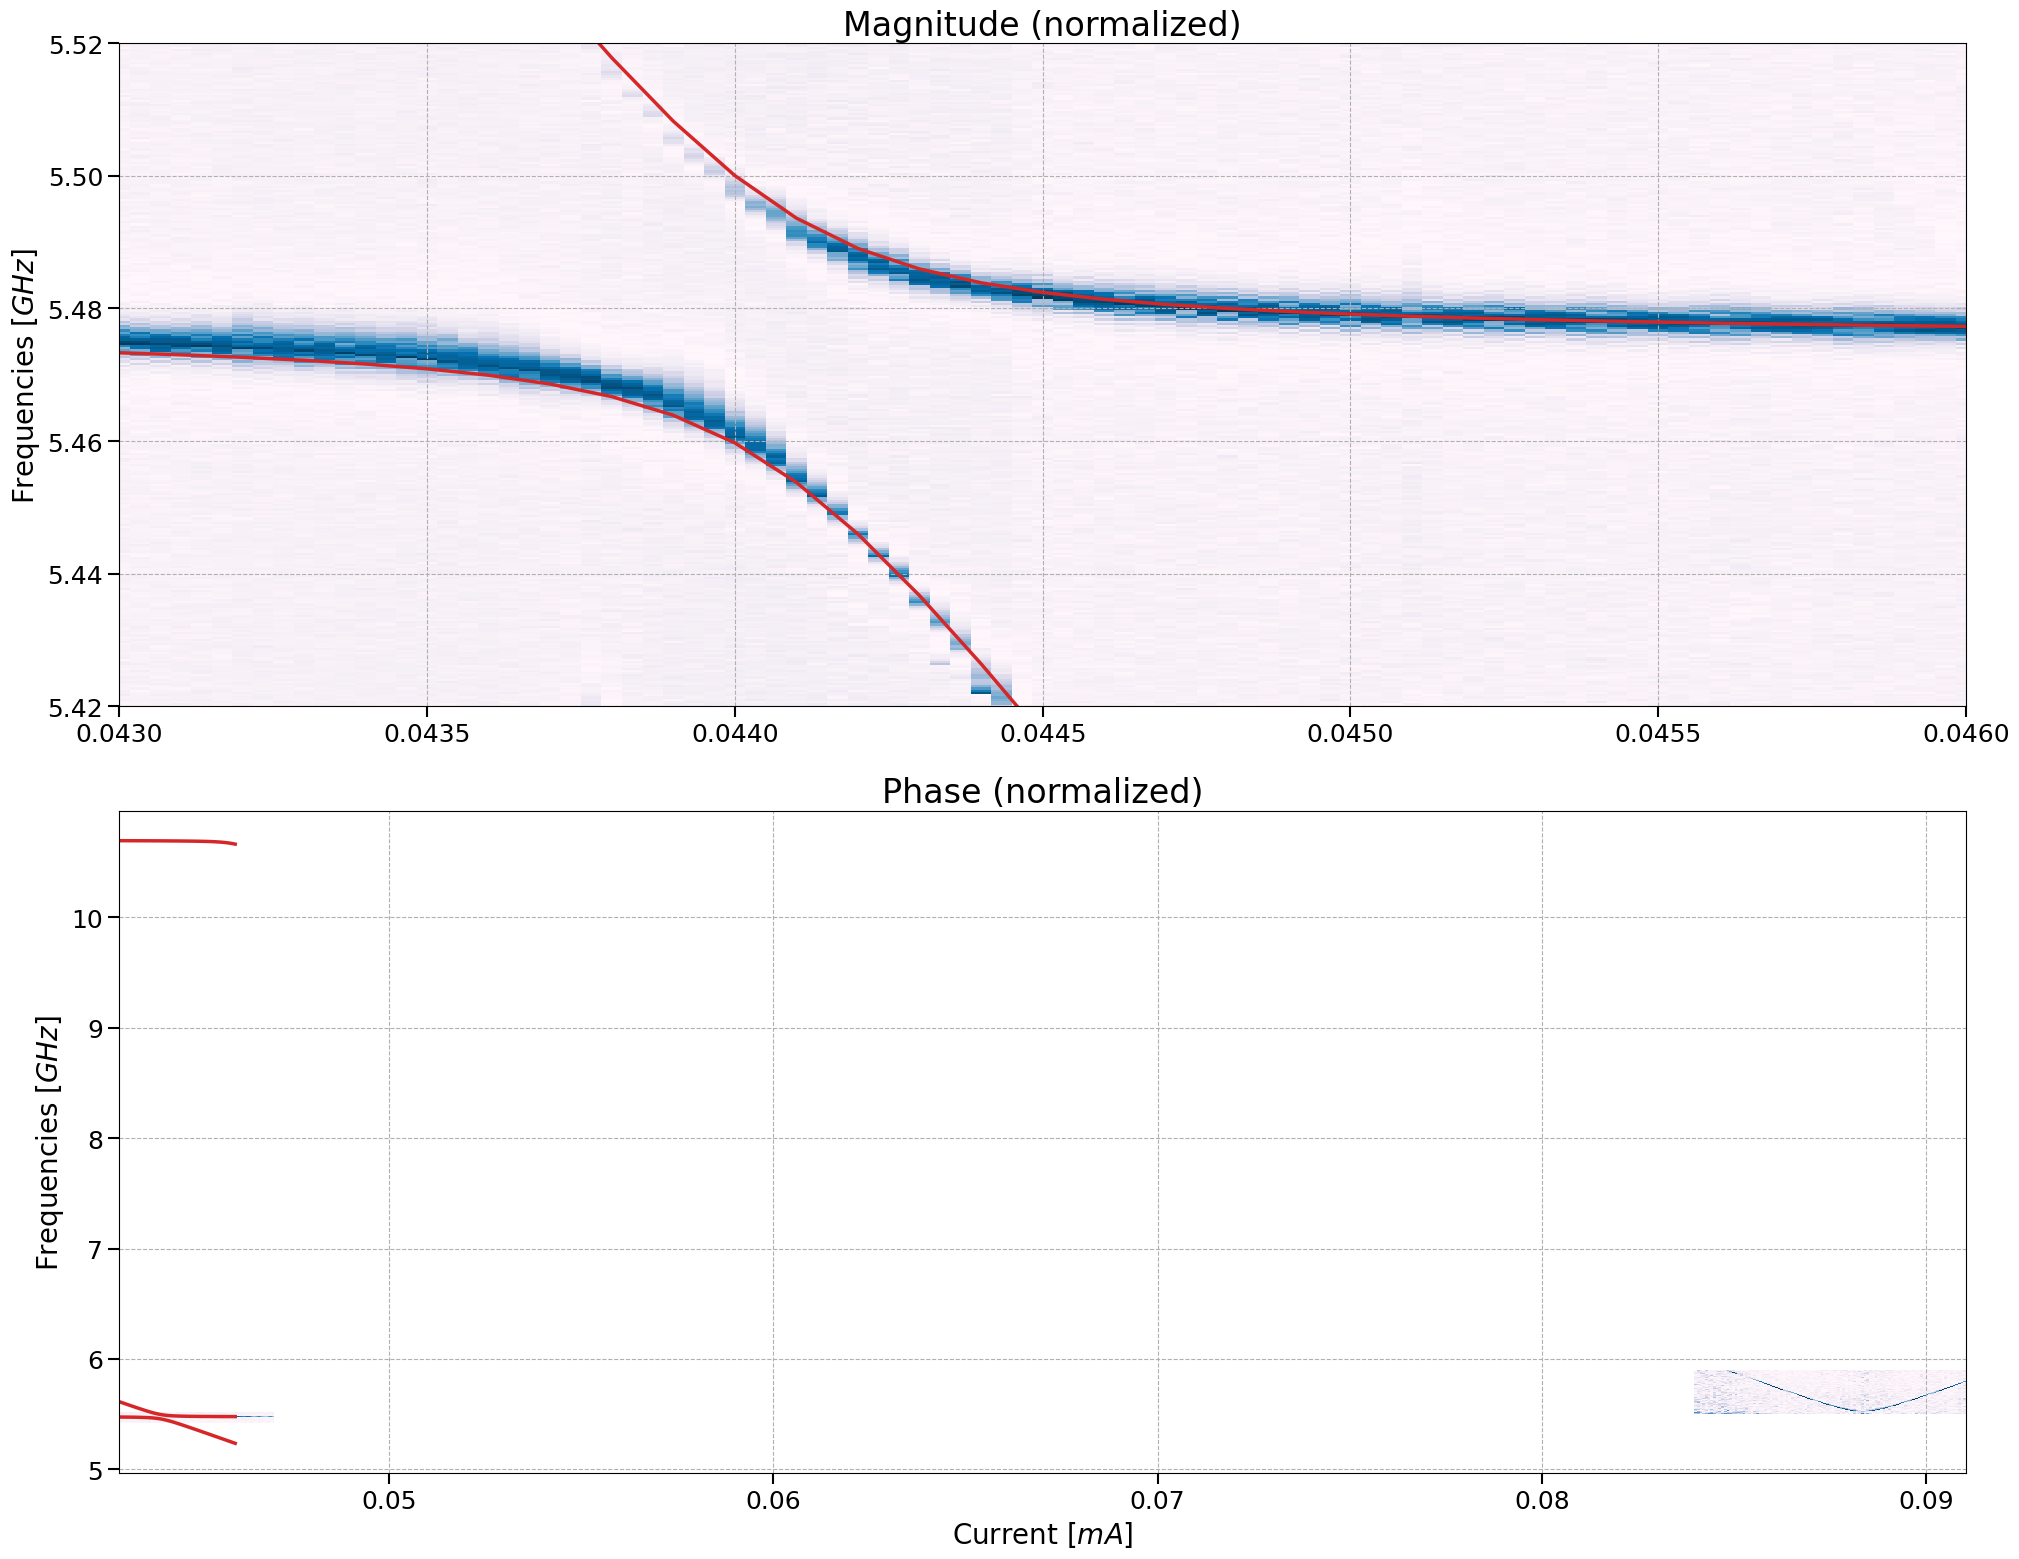

In [111]:
curr_zero_flux = -28.8e-6
curr_half_flux = 88.35e-6

curr_sweep = np.linspace(43e-6, 46e-6, 31)
# curr_sweep = np.linspace(84e-6, 91e-6, 31)
phi_sweep = current_to_flux(curr_sweep, curr_zero_flux, curr_half_flux)

vals = simulate(phi_sweep, 0.254, 15.43, 3, 20, 0.8175)

%matplotlib inline
# Base figure
# path0 = r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-11\00668-qubit_spectroscopy_vs_current_2025-10-11T034016"
# freq, data, curr, datadict = get_twotone_data(path0)
# fig, axs = plot_mag_phase(datadict=datadict, transpose=True)


fig, axs = plt.subplots(2,1, figsize=(20,16))
for d in dataz:
    plot_mag_phase(datadict=d, transpose=True, plot=(fig, axs))

axs[0].plot(curr_sweep * 1e3, vals, 'tab:red')
axs[1].plot(curr_sweep * 1e3, vals, 'tab:red')

# axs[0].set_xlim([84e-3, 91e-3])
# axs[0].set_ylim([5.42, 5.7])

axs[0].set_xlim([0.043, 0.046])
axs[0].set_ylim([5.42, 5.52])
# axs[0].set_ylim([5.42, 5.8])

plt.show()

### Simulate

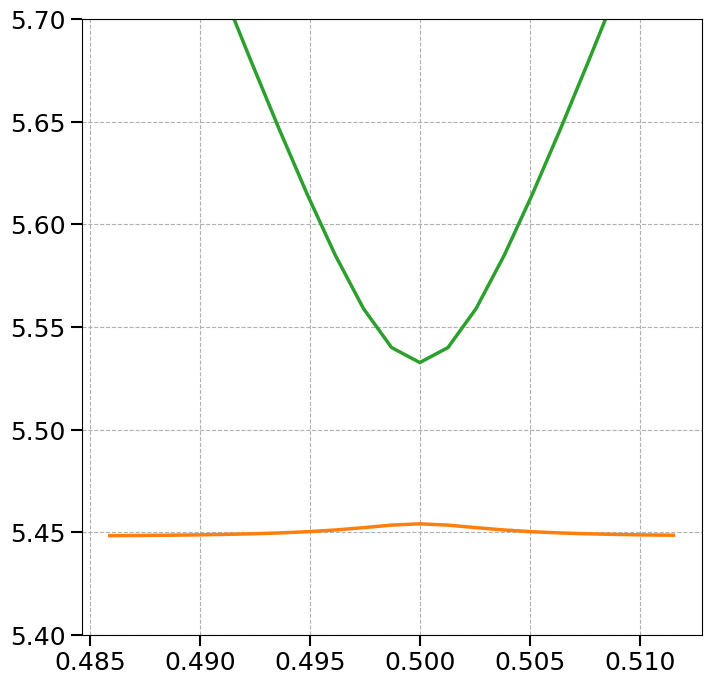

In [ ]:
curr_zero_flux = -28.8e-6
curr_half_flux = 88.3e-6

curr_sweep = np.linspace(85e-6, 91e-6, 21)
phi_sweep = current_to_flux(curr_sweep, curr_zero_flux, curr_half_flux)

vals = simulate(phi_sweep, 0.26, 15, 3, 20, 0.8)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(phi_sweep, vals)
ax.set_ylim([5.4, 5.7])
plt.show()

### Quick fit

In [6]:
from scipy.optimize import minimize
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import sqil_core as sqil

Transmon at zero flux

In [7]:
curr_zero_flux = -28.8e-6

f01 = 5.4945
f12 = 5.231

EC_s_guess = f01 - f12
EJ_t_guess = Ej_from_transmon_frequency(f01, EC_s_guess)

# Ht, *_ = get_transmon_AH(6, Ec_guess, Ej_guess)
# evals = Ht.eigenenergies()
# evals

print(f"Transmon Ec = {EC_s_guess:.3f} GHz")
print(f"Transmon Ej = {EJ_t_guess:.3f} GHz")

Transmon Ec = 0.264 GHz
Transmon Ej = 15.728 GHz


In [8]:
def simulate_g(phi_ext_sweep, EC_s, EJ_t, EC_f, EJ_f, EL):
    N_t, N_f = 3, 50
    I_t, I_f = qeye(N_t), qeye(N_f)
    N_trunc = 4

    vals_tot = np.zeros([len(phi_ext_sweep), N_trunc - 1])

    # Transmon
    H_t, _, phi_t = get_transmon_AH(N_t, EC_s, EJ_t, EL)
    evals_t, evecs_t = H_t.eigenstates()
    phi_t_01 = np.abs(evecs_t[0].dag() * phi_t * evecs_t[1])
    # Simulate vs flux
    for i, phi_ext in enumerate(phi_ext_sweep):
        # Fluxonium
        H_f, _, phi_f = get_fluxonium(N_f, EC_f, EJ_f, EL, phi_ext=phi_ext)
        evals_f, evecs_f = H_t.eigenstates()
        phi_f_01 = np.abs(evecs_f[0].dag() * phi_f * evecs_f[1])
        # Coupling
        coupling = EL * phi_t_01 * phi_f_01
        # Total hamiltonian
        H_tot = tensor(H_t, I_f) + tensor(I_t, H_f) + coupling
        evals_tot = H_tot.eigenenergies()
        # Eigenvalues
        vals_tot[i, :] = evals_tot[1:N_trunc] - evals_tot[0]

    return vals_tot

In [9]:
# Measured peaks at [-0.015, 0.020, 0.058, 0.0883, 0.1225, 0.140] mA
mvals = np.array(
    [
        [5.4945, 5.4935, 5.4865, 5.4793, 5.4784, 5.4755, 5.4681, 5.4622, 5.4283, np.nan, 4.863, 4.5582, np.nan, np.nan, np.nan, np.nan, np.nan],
        [np.nan, np.nan, np.nan, 6.3012, 6.0135, np.nan, 5.5132, 5.50, 5.4841, 5.4797, 5.4752, 5.4734, 5.4561, 5.4540, 5.4562, 5.4586, 5.4544],
        [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 6.2844, 5.6738, 5.5643, 5.5288, 5.6379],
    ]
).T

x_data = np.array([-0.029, -0.01, 0.02, 0.0375, 0.0398, 0.043, 0.04385, 0.044, 0.0444, 0.045, 0.049, 0.0515, 0.081, 0.086, 0.087, 0.087659, 0.089])

curr_zero_flux = -29e-6
curr_half_flux = 87.659e-6
phi_ext = current_to_flux(1e-3 * x_data, curr_zero_flux, curr_half_flux)


def cost(params):
    EC_s, EJ_t, EC_f, EJ_f, EL = params
    sim = simulate(phi_ext, EC_s, EJ_t, EC_f, EJ_f, EL)  # shape (n_points, n_modes)

    # Only compare the first few modes that exist in both sim and data
    n_modes = min(sim.shape[1], mvals.shape[1])
    sim = sim[:, :n_modes]
    meas = mvals[:, :n_modes]

    # Build a mask where measurement is valid
    mask = ~np.isnan(meas)
    err = (meas[mask] - sim[mask]) / sim[mask]
    return np.sum(err**2)

In [10]:
p0 = [0.264, 15.73, 3.2, 20.0, 0.8]
bounds = [(0.255, 0.275), (12, 18), (2, 6), (12, 25), (0.6, 1)]

res = minimize(cost, p0, bounds=bounds, method="L-BFGS-B")
print("Best params:", res.x)
print("Final cost:", res.fun)

Best params: [ 0.31170792 12.69510449  2.75246775 20.0626377   0.83866229]
Final cost: 2.9303129827251428e-05


In [ ]:
x_fit = np.linspace(0, 1, 2001)
x_fit_curr = 1e3 * flux_to_current(x_fit, curr_zero_flux, curr_half_flux)
# x_fit = np.linspace(0.08, 0.09, 201)
y_fit = simulate(x_fit, *res.x)

In [17]:
# Rough transmon scan
path0 = r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-07\00104-qubit_spectroscopy_vs_current_2025-10-07T023338"
%matplotlib qt
paths = [
    # |10>
    r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-13\00887-qubit_spectroscopy_vs_current_2025-10-13T031328",
    # |11>
    r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-13\00888-qubit_spectroscopy_vs_current_2025-10-13T032425",
    # anti crossing
    r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-13\00889-qubit_spectroscopy_vs_current_2025-10-13T034219",
    # others
    r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-13\00890-qubit_spectroscopy_vs_current_2025-10-13T041040",
    r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-13\00891-qubit_spectroscopy_vs_current_2025-10-13T042219",
    r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-13\00892-qubit_spectroscopy_vs_current_2025-10-13T043525",
]

datadict = sqil.extract_h5_data(path0, get_metadata=True)
qpu = sqil.read_qpu(path0, "qpu_old.json")
qu_data, qu_info, datadict = sqil.get_data_and_info(datadict=datadict)
fig, axs = sqil.plot_mag_phase(datadict=datadict["q0"], transpose=True)

for path in paths:
    datadict = sqil.extract_h5_data(path, get_metadata=True)
    qu_data, qu_info, datadict = sqil.get_data_and_info(datadict=datadict)
    sqil.plot_mag_phase(datadict=datadict["q0"], transpose=True, plot=(fig, axs))




colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][1:]
# fig, ax = plt.subplots(figsize=(6, 8))

for j in range(mvals.shape[1]):
    y_meas = mvals[:, j]
    if np.all(np.isnan(y_meas)):
        continue  # skip if column is all NaNs
    # measured points
    axs[0].plot(x_data, y_meas, "o", color=colors[j % len(colors)], label=f"mode {j}")
    # simulated curve (if available for this mode)
    if j < y_fit.shape[1]:
        axs[0].plot(x_fit_curr, y_fit[:, j], "--", color=colors[j % len(colors)], alpha=1)

plt.show()

In [ ]:
# Abs error fit
# [ 0.275      14.28479841  2.76910862 20.09526656  0.83168679]

# Rel error fit
# [ 0.285      13.80104835  2.91598115 20.03970463  0.83453955]

# 5x75
# [ 0.275      14.28493949  2.76181373 20.05985125  0.83189752]

# Free Ec
# [ 0.31170792 12.69510449  2.75246775 20.0626377   0.83866229]

### plot

In [140]:
path0 = r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-07\00104-qubit_spectroscopy_vs_current_2025-10-07T023338"
%matplotlib qt
paths = [
    # |10>
    r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-13\00887-qubit_spectroscopy_vs_current_2025-10-13T031328",
    # |11>
    r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-13\00888-qubit_spectroscopy_vs_current_2025-10-13T032425",
    # anti crossing
    r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-13\00889-qubit_spectroscopy_vs_current_2025-10-13T034219",
    # others
    r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-13\00890-qubit_spectroscopy_vs_current_2025-10-13T041040",
    r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-13\00891-qubit_spectroscopy_vs_current_2025-10-13T042219",
    r"C:\Users\sqil\Desktop\data_local\20251006_stormcrow_N17\2025-10-13\00892-qubit_spectroscopy_vs_current_2025-10-13T043525",
]

datadict = sqil.extract_h5_data(path0, get_metadata=True)
qpu = sqil.read_qpu(path0, "qpu_old.json")
qu_data, qu_info, datadict = sqil.get_data_and_info(datadict=datadict)
fig, axs = sqil.plot_mag_phase(datadict=datadict["q0"], transpose=True)

for path in paths:
    datadict = sqil.extract_h5_data(path, get_metadata=True)
    qu_data, qu_info, datadict = sqil.get_data_and_info(datadict=datadict)
    sqil.plot_mag_phase(datadict=datadict["q0"], transpose=True, plot=(fig, axs))

axs[0].set_xlabel(r"$\varphi_{ext} / \varphi_0$")
axs[0].set_ylabel("Frequency [GHz]")

axs[0].set_xticklabels([f"{current_to_flux(1e-3 * t, curr_zero_flux, curr_half_flux):.3f}" for t in np.linspace(0.0425, 0.0455, 7)])
# axs[0].set_xlim([0.0425, 0.0455])
# axs[0].set_ylim([5.42, 5.52])

# curr_zero_flux = -29e-6
# curr_half_flux = 87.635e-6
# from matplotlib.ticker import MaxNLocator
# axs[0].xaxis.set_major_locator(MaxNLocator(nbins=11))
# axs[0].set_xticklabels([
#     f"{current_to_flux(1e-3 * t, curr_zero_flux, curr_half_flux):.3f}" 
#     for t in np.linspace(1e3*curr_half_flux-2e-3,1e3*curr_half_flux+2e-3, 11)
#     ])
# axs[0].set_xlim([1e3*curr_half_flux-2e-3,1e3*curr_half_flux+2e-3])
# axs[0].set_ylim([5.43, 5.75])

# fig.set_size_inches(12,20)

axs[1].set_title("")
plt.show()

C:\Users\sqil\AppData\Local\Temp\ipykernel_44360\3261353498.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels([f"{current_to_flux(1e-3 * t, curr_zero_flux, curr_half_flux):.3f}" for t in np.linspace(0.0425, 0.0455, 7)])


In [141]:
[
    f"{current_to_flux(1e-3 * t, curr_zero_flux, curr_half_flux):.3f}"
    for t in np.linspace(0.0425, 0.0455, 7)
]

['0.307', '0.309', '0.311', '0.313', '0.315', '0.317', '0.319']

In [35]:
axs[0].get_xticks()

array([-0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,
        0.12])

In [36]:
current_to_flux(1e-3 * axs[0].get_xticks(), curr_zero_flux, curr_half_flux)

array([-0.13286587, -0.04714596,  0.03857396,  0.12429388,  0.2100138 ,
        0.29573372,  0.38145364,  0.46717356,  0.55289348,  0.63861339])